<a href="https://colab.research.google.com/github/Aman-Singh-Akhand/GSOC-2025-Deep-Lens/blob/main/Specific_Test_II_Lens_Finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Specific Test II. Lens Finding**
For this task I have used CNN network with CONV2D and Maxpooling layers. I have used two such blocks folwed by flattening and dense layers. I used Keras hyperband tuning for the optimization of hyperparameters. Validation accuracy of approximately 95% was obtained.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install keras scikit-learn matplotlib keras-tuner
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 586.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import keras_tuner as kt
import matplotlib.pyplot as plt

# Function to load data from a given directory
def load_data(directory):
    images = []
    labels = []
    #I have modified the original folders. I have made separate folders for train and test
    for label, folder in enumerate(["lenses", "nonlenses"]):
        folder_path = os.path.join(directory, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".npy"):
                img = np.load(os.path.join(folder_path, file_name))
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [6]:
# Loading training and test data from folders 'train' and 'test'
train_images, train_labels = load_data('/content/drive/MyDrive/GSC/lens-finding-test/train')
test_images, test_labels = load_data('/content/drive/MyDrive/GSC/lens-finding-test/test')

# Normalize the data
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape images to match Keras input requirements (64x64 with 3 channels)
train_images = train_images.reshape(-1, 64, 64, 3)
test_images = test_images.reshape(-1, 64, 64, 3)

# Split training data for validation during tuning
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [7]:
# CNN network for classification
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [8]:
# Set up KerasTuner (Hyperband)
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     hyperband_iterations=2,
                     directory='keras_tuner_dir',
                     project_name='lens_identification')

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Retrieve the best model from tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model to file
best_model.save('best_lens_model.h5')


Trial 60 Complete [00h 02m 58s]
val_accuracy: 0.9528037905693054

Best val_accuracy So Far: 0.9546127319335938
Total elapsed time: 02h 36m 00s


Test Accuracy: 0.9819, Test Loss: 0.0569
615/615 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step
AUC: 0.9341


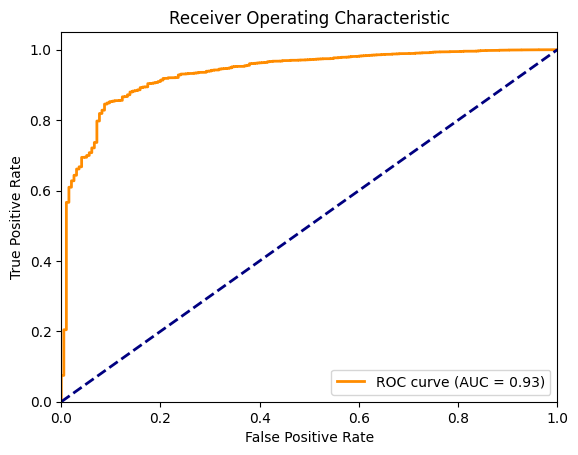

In [9]:
# The best model on the test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

y_pred_prob = best_model.predict(test_images)

# ROC curve and AUC score
fpr, tpr, _ = roc_curve(test_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Plot of ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [2]:
%%shell
jupyter nbconvert --to html /content/Specific_Test_II_Lens_Finding.ipynb

[NbConvertApp] Converting notebook /content/Specific_Test_II_Lens_Finding.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 354471 bytes to /content/Specific_Test_II_Lens_Finding.html
